<a href="https://colab.research.google.com/github/Bone-Age-Maisha/paper_1/blob/main/SEnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras.utils

In [13]:
import numpy as np
import pandas as pd 
import os
import sklearn.datasets 
import sklearn.model_selection 
import keras.preprocessing.image 
import keras.utils 
import matplotlib.pyplot as plt 
from keras.preprocessing.image import ImageDataGenerator 
from skimage import color 
from sklearn.metrics import accuracy_score
import keras.callbacks 
import os 
import numpy as np 
import cv2


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-gpu

In [ ]:
!nvidia-smi

In [17]:
import pandas as pd
train_dir = '/content/drive/MyDrive/small_data/train'
df = pd.read_csv('/content/drive/MyDrive/small_data/train_csv1.csv')

#data processing ------------------------------

In [ ]:
from six.moves import cPickle
X_train = []
y_age = []
y_gender = []

#df = pd.read_csv('/raid/chenchao/code/BoneAge/BoneAge/data/Training.csv')
a = df.values
m = a.shape[0]

cnt=1
path = train_dir
k = 0
print ('Loading data set...')
k=1
for i in os.listdir(path):
  #print(i)
  print(cnt)
  cnt=cnt+1
  if(len(i)>9):   #errror occuring  so to 
    continue
  y_age.append(df.boneage[df.id == int(i[:-4])].tolist()[0])
  a = df.male[df.id == int(i[:-4])].tolist()[0]
  if a:
    y_gender.append(1)
  else:
     y_gender.append(0)
  img_path = path + "/"+i
  img = cv2.imread(img_path)
  #print(img.shape)
  print (img_path)
  img = cv2.imread(img_path)
    #print (img_path)
    #if(img is not None):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(256,256))
  x = np.asarray(img, dtype=np.uint8)
  X_train.append(x)
    
print ('100% completed loading data')

# Save data
train_pkl = open('/content/drive/MyDrive/data.pkl','wb')
cPickle.dump(X_train, train_pkl, protocol=cPickle.HIGHEST_PROTOCOL)
train_pkl.close()

train_age_pkl = open('/content/drive/MyDrive/data_age.pkl','wb')
cPickle.dump(y_age, train_age_pkl, protocol=cPickle.HIGHEST_PROTOCOL)
train_age_pkl.close()

train_gender_pkl = open('/content/drive/MyDrive/data_gender.pkl','wb')
cPickle.dump(y_gender, train_gender_pkl, protocol=cPickle.HIGHEST_PROTOCOL)
train_gender_pkl.close()



In [22]:
def SaveImg(filename,filepath,heatmap):
    img = cv2.imread(filepath)
    heatmap = cv2.resize(heatmap,(img.shape[1],img.shape[0]))
    AttentionImg =0.5* heatmap + img
    cv2.imwrite('/content/heat'+filename,heatmap)
    cv2.imwrite('/content/attention'+filename,AttentionImg)


def load_image(path):
    img = cv2.imread(path)
    print(img.shape)
    img = cv2.resize(img,(256,256))   ##my own edit
    print(img.shape)
    x = np.asarray(img, dtype=np.float32)
   # img = image.load_img(path, target_size=(448, 448))
   # print (img.shape)
   # x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x




def softlabel(label,num_class):
    softlabel=np.zeros((len(label),num_class))
    ratio = 1.0/50
    for i in range(len(label)):
        for j in range(num_class):
            softlabel[i,j]=1.0 - ratio*np.abs(j-label[i])
    softlabel = np.maximum(softlabel,0)
    return softlabel



def GaussLabel(label,num_class):
    sigma=15.0
    GaussLabel = np.zeros((len(label),num_class))
    x = np.array(range(num_class))+1
    for k in range(len(label)):
        GaussLabel[k,:]=np.exp(-(x-label[k])**2/(2.0*sigma**2))
    return GaussLabel


def TestMAE(model,test_data,test_label,test_gender):
    test_gender = np.array(test_gender)
    test_gender = np.expand_dims(test_gender,axis=1)
    layer=K.function([model.layers[0].input,model.layers[3].input],[model.layers[-1].output])
    predictions=layer([test_data,test_gender])
    predictions = np.array(predictions)
    predictions = np.squeeze(predictions,axis=0)
    print (predictions.shape)
    predict_label = np.argmax(predictions,axis=1)
    test_label = np.argmax(test_label,axis=1)
    print (predict_label)
    print (test_label)
    TestMAE = np.mean(np.abs(predict_label-test_label))
    return TestMAE



In [24]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
import tensorflow as tf
from keras import backend as K
import pickle
import numpy as np
import matplotlib.pyplot as plt
import keras
#from func_utils import *
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="2"
#os.environ['OMP_NUM_THREADS']='6'
batch_size = 32
epochs = 30

# Load data
print('...loading training data')
f = open('/content/drive/MyDrive/data.pkl', 'rb')
x = pickle.load(f)
f.close()

f = open('/content/drive/MyDrive/data_age.pkl', 'rb')
y = pickle.load(f)
f.close()

f = open('/content/drive/MyDrive/data_gender.pkl','rb')
gender = pickle.load(f)
f.close()


x = np.asarray(x, dtype=np.float32)
y = np.asarray(y)
gender = np.asarray(gender)

x /= 255.
gender =2*( gender-0.5)
x_final = []
y_final = []
gender_final = []

# Shuffle images and split into train, validation and test sets
#random_no = np.random.choice(x.shape[0], size=x.shape[0], replace=False)
random_no = np.arange(x.shape[0])
#print(random_no)
np.random.seed(0)
np.random.shuffle(random_no)
for i in random_no:
    x_final.append(x[i,:,:,:])
    y_final.append(y[i])
    gender_final.append(gender[i])

x_final = np.asarray(x_final)
y_final = np.asarray(y_final)
gender_final = np.asarray(gender_final)
print (y_final[:50])
print (gender_final[:50])
k = 10 # Decides split count
x_test = x_final[:k,:,:,:]
y_test = y_final[:k]
gender_test = gender_final[:k]
x_valid = x_final[k:2*k,:,:,:]
y_valid = y_final[k:2*k]
gender_valid = gender_final[k:2*k]
x_train = x_final[2*k:,:,:,:]
y_train = y_final[2*k:]
gender_train = gender_final[2*k:]

## 
#y_test = keras.utils.to_categorical(y_test,240)
#y_train = keras.utils.to_categorical(y_train,240)
#y_valid = keras.utils.to_categorical(y_valid,240)
y_train = softlabel(y_train,240)
y_valid = softlabel(y_valid,240)
y_test = softlabel(y_test,240)
print (y_train)


print ('x_train shape:'+ str(x_train.shape))
print ('y_train shape:'+ str(y_train.shape))
print ('gender_train shape:'+ str(gender_train.shape))
print ('x_valid shape:'+ str(x_valid.shape))
print ('y_valid shape:'+ str(y_valid.shape))
print ('gender_valid shape:' + str(gender_valid.shape))
print ('x_test shape:'+ str(x_test.shape))
print ('y_test shape:'+ str(y_test.shape))




...loading training data
[126  30 170  24  33 180 150  94  24  32  60 149  78  54 162 165 126  69
 174  94  90 113 120  32 156  82  42  54 126 156  27 136 156  88 132  21
 188 156 108 126  36 180  57  36 120 132 192 156 138 159]
[ 1. -1.  1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1.
  1. -1.  1. -1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1.  1. -1.]
[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.02 0.04 ... 0.   0.   0.  ]
 [0.52 0.54 0.56 ... 0.   0.   0.  ]
 [0.34 0.36 0.38 ... 0.   0.   0.  ]]
x_train shape:(51, 256, 256, 3)
y_train shape:(51, 240)
gender_train shape:(51,)
x_valid shape:(10, 256, 256, 3)
y_valid shape:(10, 240)
gender_valid shape:(10,)
x_test shape:(10, 256, 256, 3)
y_test shape:(10, 240)


#model build--------------------

In [25]:
images = keras.layers.Input((256,256,3),name='input1')

#inizio blocco 1
x = keras.layers.Conv2D(filters=16, kernel_size=[1, 1], padding='same')(images)
block = keras.layers.Conv2D(filters=16, kernel_size=[3, 3], padding="same")(x)
block = keras.layers.BatchNormalization()(block)
block = keras.layers.Activation("relu")(block)
block = keras.layers.Conv2D(filters=16, kernel_size=[3, 3], padding="same")(block)

#inio Squeeze and Excitation 1
sq = keras.layers.GlobalAveragePooling2D()(block)
sq = keras.layers.Reshape((1,1,16))(sq)
sq = keras.layers.Dense(units=16,activation="sigmoid")(sq)
block = keras.layers.multiply([block,sq])
#fine Squeeze and Excitation 1

net = keras.layers.add([x,block])
net = keras.layers.BatchNormalization()(net)
net = keras.layers.Activation("relu")(net)
net = keras.layers.MaxPooling2D(pool_size=(2, 2),name="block_1")(net)



#fine blocco 1
#inizio blocco 2
x = keras.layers.Conv2D(filters=32, kernel_size=[1, 1], padding='same')(net)
block = keras.layers.Conv2D(filters=32, kernel_size=[3, 3], padding="same")(x)
block = keras.layers.BatchNormalization()(block)
block = keras.layers.Activation("relu")(block)
block = keras.layers.Conv2D(filters=32, kernel_size=[3, 3], padding="same")(block)

#inio Squeeze and Excitation 2
sq = keras.layers.GlobalAveragePooling2D()(block)
sq = keras.layers.Reshape((1,1,32))(sq)
sq = keras.layers.Dense(units=32,activation="sigmoid")(sq)
block = keras.layers.multiply([block,sq])
#fine Squeeze and Excitation 2


net = keras.layers.add([x,block])
net = keras.layers.BatchNormalization()(net)
net = keras.layers.Activation("relu")(net)
net = keras.layers.MaxPooling2D(pool_size=(2, 2),name="block_2")(net)
#fine blocco 2
#inizio blocco 3
x = keras.layers.Conv2D(filters=64, kernel_size=[1, 1], padding='same')(net)
block = keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding="same")(x)
block = keras.layers.BatchNormalization()(block)
block = keras.layers.Activation("relu")(block)
block = keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding="same")(block)

#inio Squeeze and Excitation 3
sq = keras.layers.GlobalAveragePooling2D()(block)
sq = keras.layers.Reshape((1,1,64))(sq)
sq = keras.layers.Dense(units=64,activation="sigmoid")(sq)
block = keras.layers.multiply([block,sq])
#fine Squeeze and Excitation 3

net = keras.layers.add([x,block])
net = keras.layers.Activation("relu", name="block_3")(net)



net = keras.layers.BatchNormalization()(net)
net = keras.layers.Dropout(0.25)(net)

net = keras.layers.GlobalAveragePooling2D()(net)
net = keras.layers.Dense(units=240,activation="softmax")(net)

model = keras.models.Model(inputs=images,outputs=net)


model.summary()
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 256, 256, 16  64          ['input1[0][0]']                 
                                )                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  2320        ['conv2d_18[0][0]']              
                                )                                                           

In [29]:
Adam=tf.keras.optimizers.Adam(lr=0.0003,beta_1=0.9,beta_2=0.999)
model.compile(loss='mean_absolute_error',optimizer=Adam,  metrics=['MAE'])
checkpointer = keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/se.hdf5', verbose = 1, save_best_only = True)
earlystopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.


In [30]:
history=model.fit(x_train, y_train, batch_size=26, epochs=50,validation_data=(x_valid, y_valid), callbacks = [checkpointer,earlystopper], shuffle=True)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - ETA: 0s - loss: 0.2027 - MAE: 0.2027WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f58aa707830> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: val_loss improved from inf to 0.20906, saving model to /content/drive/MyDrive/se.hdf5
2/2 [==============================] - 2s 710ms/step - loss: 0.2027 - MAE: 0.2027 - val_loss: 0.2091 - val_MAE: 0.2091
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 0.2027 - MAE: 0.2027
Epoch 2: val_loss did not improve from 0.20906
2/2 [==============================] - 0s 190ms/step - loss: 0.2027 - MAE: 0.2027 - val_loss: 0.2091 - val_MAE: 0.2091
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 0.2027 - MAE: 0.2027
Epoch 3: val_loss did not improve from 0.20906
2/2 [==============================] - 0s 192ms/step - 

In [31]:
model.load_weights('/content/drive/MyDrive/se.hdf5')

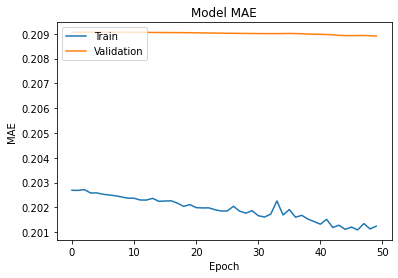

In [32]:
plt.plot(history.history['MAE'])
plt.plot(history.history['val_MAE'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [34]:
y_test_pred = model.predict(x_test)
//accuracy_score(np.argmax(y_test_pred,axis=1), np.argmax(y_test,axis=1))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


0.0

In [35]:
score = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

1/1 [==============================] - 0s 56ms/step - loss: 0.2001 - MAE: 0.2001
Test loss: 0.20012840628623962
Test MAE: 0.20012840628623962
